## Introduction

## Loading the dataset & Data Preparation

In [17]:
# Select data directory
asl_data_dir = "datasets/asl_dataset"

##### Generating the dataset with Keras image data preprocessing

In [18]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras

In [19]:
# dataset generation
asl_data = tf.keras.preprocessing.image_dataset_from_directory(asl_data_dir)

Found 2471 files belonging to 36 classes.


##### Image Augmentation & Training, Validation, and Test set with Keras Image data generator
Reference: https://keras.io/api/preprocessing/image/

In [13]:
# Importing necessary libraries
from keras.preprocessing.image import ImageDataGenerator


In [20]:
# Data generator argument
datagen_args = dict(
        rescale = 1./255, 
        rotation_range = 20, 
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        validation_split = 0.25
)

# Define arguments for the Model
height = 256
width = 256
channels = 3
batch_size = 128
target_shape = (height, width, channels)
target_size = (height, width)
num_classes = len(asl_data.class_names)

# Data generator object
datagen = ImageDataGenerator(**datagen_args)

# Split Tests
train_generator = datagen.flow_from_directory(
    asl_data_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    asl_data_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 1870 images belonging to 36 classes.
Found 601 images belonging to 36 classes.


## Data Exploration

In [13]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Function to display the image
plt.figure(figsize=(15, 15))
def display_img(dataset):
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(asl_data.class_names[labels[i]])
            plt.axis("off")

<Figure size 1080x1080 with 0 Axes>

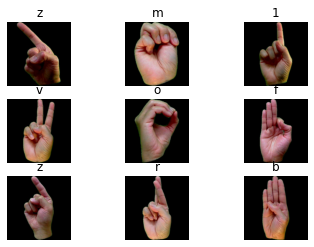

In [8]:
# Displaying the images in the dataset
display_img(asl_data)

## Defining the Model

We will use transfer learning, a pre-trained model on our dataset. It allows us to save training time and perform better even with a relatively small dataset.

We use the Inception v3 model developed by Google. The Inception v3 is a Convolution Neural Network image recognition model based on Szegedy's Inception introduced in their paper Going deeper with convolution in 2014. Inception historically attained a significant accuracy in ImageNet Large Scale Visual Recognition Challenge in 2014. The model is the culmination of many ideas developed by multiple researchers.

More on transfer learning: https://en.wikipedia.org/wiki/Transfer_learning

more on Inception: https://cloud.google.com/tpu/docs/tutorials/inception

https://keras.io/api/applications/inceptionv3/

In [21]:
# Importing necessary libraries
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU

In [22]:
# Using random Data augmentation
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [23]:
# Loading the pre-trained Inception model
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=target_shape, 
    pooling='avg'
)

In [24]:
# Freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [25]:
# Building on top of the inceptionv3 model
x = base_model.output

x = Conv2D(1024, kernel_size=(3, 3), activation='linear', padding='same', input_shape=target_shape)(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2D(128, kernel_size=(3, 3), activation='linear', padding='same', input_shape=target_shape)(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
# and a logistic layer -- we have 36 classes
predictions = Dense(num_classes, activation='softmax')(x)

ValueError: Input 0 of layer "conv2d_94" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 2048)

In [43]:

# add a global batch normalization layer
x = base_model.output
x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
# and a logistic layer -- we have 36 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs = base_model.input, outputs = predictions)
# compile the model
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



In [44]:
# Lets view the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

## Training the Model

In [46]:
# train the model on the new data for a few epochs
history = model.fit(
    train_generator, 
    validation_data = validation_generator,
    epochs = 10
)

Epoch 1/10
15/15 [==============================] - 88s 6s/step - loss: 2.6208 - accuracy: 0.2904 - val_loss: 2.7669 - val_accuracy: 0.1963
Epoch 2/10
15/15 [==============================] - 82s 5s/step - loss: 1.5351 - accuracy: 0.5150 - val_loss: 2.3525 - val_accuracy: 0.3028
Epoch 3/10
15/15 [==============================] - 87s 6s/step - loss: 1.1899 - accuracy: 0.6214 - val_loss: 2.0823 - val_accuracy: 0.3860
Epoch 4/10
15/15 [==============================] - 84s 6s/step - loss: 1.0006 - accuracy: 0.6743 - val_loss: 1.8248 - val_accuracy: 0.5092
Epoch 5/10
15/15 [==============================] - 79s 5s/step - loss: 0.9271 - accuracy: 0.7102 - val_loss: 1.6786 - val_accuracy: 0.5474
Epoch 6/10
15/15 [==============================] - 79s 5s/step - loss: 0.8577 - accuracy: 0.7155 - val_loss: 1.4976 - val_accuracy: 0.5824
Epoch 7/10
15/15 [==============================] - 86s 6s/step - loss: 0.7618 - accuracy: 0.7513 - val_loss: 1.3380 - val_accuracy: 0.6023
Epoch 8/10
15/15 [==

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

In [47]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [48]:
# we chose to train the top 10 inception blocks, i.e. we will freeze
# the first 301 layers and unfreeze the rest:
for layer in model.layers[:301]:
   layer.trainable = False
for layer in model.layers[301:]:
   layer.trainable = True

In [49]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# Import callback functions
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Monitor the performance, stop training if performance dip
stop = EarlyStopping(patience = 15)

# Change learning rate if performance is bad
l_rate_reduce = ReduceLROnPlateau(monitor="val_accuracy", min_lr=0.001)

callbacks=[stop, l_rate_reduce]

# we train our model again (this time fine-tuning the top 10 inception blocks
# alongside the top Dense layers

In [51]:
# Fiting the model
history += model.fit(
    train_generator, 
    validation_data = validation_generator,
    callbacks = callbacks,
    epochs = 30
)

Epoch 1/30
15/15 [==============================] - 88s 6s/step - loss: 0.6100 - accuracy: 0.7909 - val_loss: 1.0125 - val_accuracy: 0.6789 - lr: 1.0000e-04
Epoch 2/30
15/15 [==============================] - 81s 5s/step - loss: 0.5977 - accuracy: 0.8235 - val_loss: 0.9420 - val_accuracy: 0.7055 - lr: 1.0000e-04
Epoch 3/30
15/15 [==============================] - 82s 6s/step - loss: 0.6094 - accuracy: 0.7898 - val_loss: 0.9358 - val_accuracy: 0.6889 - lr: 1.0000e-04
Epoch 4/30
15/15 [==============================] - 83s 6s/step - loss: 0.5690 - accuracy: 0.8053 - val_loss: 0.8803 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 5/30
15/15 [==============================] - 82s 6s/step - loss: 0.5424 - accuracy: 0.8059 - val_loss: 0.8305 - val_accuracy: 0.7038 - lr: 1.0000e-04
Epoch 6/30
15/15 [==============================] - 84s 6s/step - loss: 0.5485 - accuracy: 0.8107 - val_loss: 0.8121 - val_accuracy: 0.7321 - lr: 1.0000e-04
Epoch 7/30
15/15 [==============================] - 82s 5s

TypeError: unsupported operand type(s) for +=: 'History' and 'History'

In [54]:
## Saving the model
model.save('sign_lang_detect_inceptv3_model_tuned_v2.h5', save_format = 'h5')

## Model Validation

#### Plot the model training and validation data

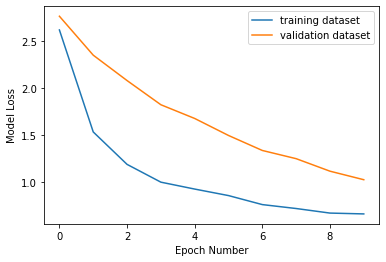

In [53]:
# Plot of the model training and validation loss
plt.xlabel('Epoch Number')
plt.ylabel('Model Loss')
plt.plot(history.history['loss'], label='training dataset')
plt.plot(history.history['val_loss'], label='validation dataset')
plt.legend()

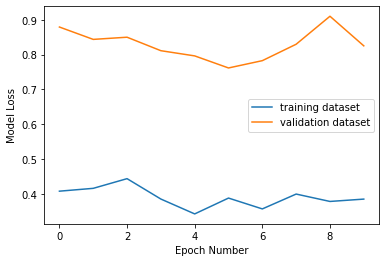

In [32]:
# Plot of the model training and validation loss
plt.xlabel('Epoch Number')
plt.ylabel('Model Loss')
plt.plot(history_tuned.history['loss'], label='training dataset')
plt.plot(history_tuned.history['val_loss'], label='validation dataset')
plt.legend()

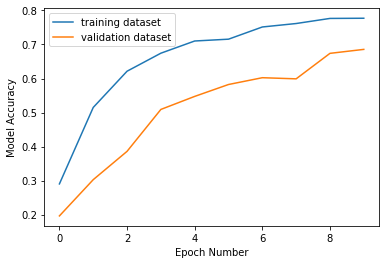

In [52]:
# Plot of the model training and validation accuracy
plt.xlabel('Epoch Number')
plt.ylabel('Model Accuracy')
plt.plot(history.history['accuracy'], label='training dataset')
plt.plot(history.history['val_accuracy'], label='validation dataset')
plt.legend()

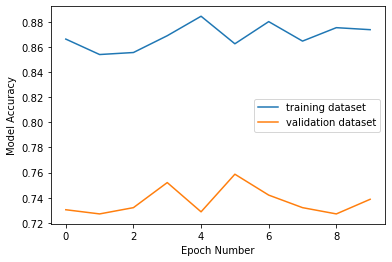

In [34]:
plt.xlabel('Epoch Number')
plt.ylabel('Model Accuracy')
plt.plot(history_tuned.history['accuracy'], label='training dataset')
plt.plot(history_tuned.history['val_accuracy'], label='validation dataset')
plt.legend()

#### Predicting an unseen image

In [6]:
# Importing necessary libraries
from tensorflow.keras.preprocessing import image
import numpy as np
from keras.models import load_model

In [37]:
# Function to predict an image
def prediction(image_data, model):
    #img = image.load_img(image_data, target_size = target_size)
    img_arr = image.smart_resize(image_data, target_size)
    #img_arr = image.img_to_array(img_arr)
    prediction_result = ""

    processed_old = np.expand_dims(img_arr, axis=0)
    processed = processed_old / 255.

    predicted_class = model.predict(processed)

    index = np.argmax(predicted_class)

    # predicted_probabilities = list(
    #     map("{:.2f}%".format, 
    #     predicted_class[0]*100)
    # )

    predicted_probabilities = list(
        map('{:.2f}'.format,
        predicted_class[0]*100)
    )

    if(float(predicted_probabilities[index]) > 50):
        prediction_result = "Prediction : {} \n Probability : {}%".format(str(asl_data.class_names[index]).title(), predicted_probabilities[index])
        plt.title(prediction_result, 
        size=18, 
        color='green'
        )
        plt.imshow(image_data)
        print(predicted_class)
    else:
        prediction_result = "Could not predict, try again"
        plt.title(prediction_result, 
        size=18, 
        color='red'
        )
        plt.imshow(image_data)

    return prediction_result



In [3]:
# import necessary modules
import glob, random

In [35]:
# Select random unseen test image
file_path_type = "datasets/asl_test_dataset/*.jpeg"
def rand_img():
    img = glob.glob(file_path_type)
    rand_img = random.choice(img)
    rand_img = image.load_img(rand_img, target_size = target_size)
    return rand_img

In [144]:
rand_img()

'datasets/asl_test_dataset\\hand1_q_right_seg_4_cropped.jpeg'

[[4.2838715e-07 5.3862284e-08 1.6743470e-02 1.8943194e-06 7.8275943e-06
  1.3398414e-07 5.8344841e-01 7.0983418e-03 4.6354524e-04 1.5880096e-04
  4.3051333e-08 2.4496028e-05 3.7731793e-06 1.4210539e-07 6.9860727e-07
  1.7114900e-05 4.5035495e-07 1.5020935e-05 4.0483819e-06 5.5268544e-07
  6.6828062e-03 1.5336578e-07 1.8138778e-07 4.2963730e-08 6.4799160e-06
  4.7978119e-06 4.2668370e-07 1.4203490e-02 9.2704742e-09 3.2814523e-07
  1.1917674e-03 6.8928604e-04 3.6921999e-01 9.7484944e-06 2.8683775e-07
  8.2444114e-07]]


'Prediction : 6 \n Probability : 58.34%'

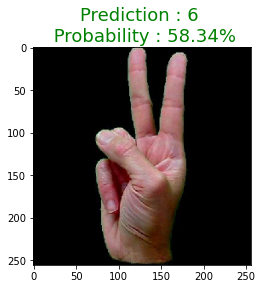

In [38]:
model = load_model("sign_lang_detect_inceptv3_model_tuned_v2.h5")
prediction(rand_img(), model)

## The Model in Action

We will build a real time system to detect a hand sign. We will have a live feed from the video cam and every frame that detects a hand in the region of interest, the model with predict it.

To differentiate between the background and the object to predict, we calculate the accumulated weighted avg for the background and then subtract this from the frames that contain the object. We calculate the accumulated weight for the background for 30 frames then subtract it from every frames that contains an object after 30 frames. This detects any object that blocks the background.


In [15]:
# Import Necessary modules
import cv2
from keras.models import load_model

# Define necessary variables
background = None
accumulated_weight = 0.3
limit = 25

# Dimensions for detection region
detect_region_top = 50
detect_region_bottom = 350
detect_region_left = 350
detect_region_right = 50

In [16]:
# Function to accumulate weight for the background
def accumulated_average(frame, accumulated_weight):
    global background

    if background is None:
        background = frame.copy().astype("float")
        return None
    
    cv2.accumulateWeighted(frame, background, accumulated_weight)

Now we determine the contour of our detection area. With the contour detect, we can determine whether a hand is present.

In [17]:
# Function to detect the presence of an object in the detection area
def detect_hand(frame, limit=25):
    global background
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(background.astype("uint8"), frame)

    ret, threshold_img = cv2.threshold(diff, limit, 255, cv2.THRESH_BINARY)

    # Get the external contours for the image
    # check OpenCV version
    major = cv2.__version__.split('.')[0]
    if major == '3':
        ret, contours, hierarchy = cv2.findContours(threshold_img.copy(),
         cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours, hierarchy = cv2.findContours(threshold_img.copy(), 
         cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(contours) == 0:
        return None
    else:
        # based on contour area, get the maximum contour which is the hand
        hand_segmented = max(contours, key=cv2.contourArea)
        return (threshold_img, hand_segmented)

Subtract the background from the image 

In [26]:
def subtract_background(front_frame, mask_frame):
    # Resize the frames to match the size
    img = image.smart_resize(front_frame, target_size)
    mask_frame = cv2.resize(mask_frame, target_size)

    background_img = cv2.imread("background_black.png")
    background_img = cv2.resize(background_img, target_size)

    # Return true when pixel values > 0.5
    condition = np.stack((mask_frame,) * 3, axis=-1) > 0.5

    # combine frame and background image using the condition
    new_img = np.where(condition, img, background_img)

    return new_img

When a hand is present in the detection area, we predict it.

In [19]:
capture = cv2.VideoCapture(0)

numb_frames = 0

hand_tuned_model = load_model("sign_lang_detect_inceptv3_model_tuned_v2.h5")

hand_prediction = {0: 'No sign language', 1: 'Sign language detected'}

[[4.40919679e-03 9.34023137e-06 4.61474738e-05 1.11356298e-04
  6.11242467e-06 8.84295441e-05 1.87337150e-06 5.01459508e-05
  1.29845372e-04 1.07335645e-05 4.52733540e-04 1.35421974e-03
  1.25975339e-02 2.97926903e-07 1.97371037e-06 1.04665096e-05
  3.33320573e-02 2.92955345e-04 3.21576517e-05 1.28731190e-03
  2.63149491e-06 4.02693549e-05 9.10565795e-05 1.44595641e-03
  7.25689868e-04 3.47486028e-04 8.12891126e-01 1.31300976e-03
  7.62816126e-06 1.73209398e-03 1.40959804e-04 1.50924570e-05
  2.85276910e-04 1.13045104e-01 6.77734241e-03 6.91440888e-03]]
[[4.4044768e-03 3.3253011e-05 3.1310090e-04 5.0312548e-05 9.6165959e-06
  1.2645172e-04 1.0184901e-05 3.8704745e-04 5.3821789e-04 2.3685190e-05
  9.1741649e-06 1.5157214e-04 5.7916599e-03 3.7931207e-07 7.4987139e-07
  2.3821831e-07 2.8421619e-04 2.4472849e-04 5.3359595e-06 1.3480531e-05
  8.1266529e-07 3.7315054e-05 8.0054888e-06 1.1375116e-04 5.8664083e-03
  7.5099437e-04 9.7461933e-01 7.8008178e-04 5.1608022e-06 1.9348193e-04
  2.6138

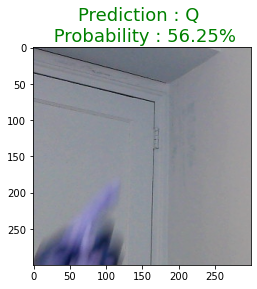

In [39]:
cv2.namedWindow("American Sign Detection")
capture = cv2.VideoCapture(0)

numb_frames = 0

if capture.isOpened(): # try to get the first frame
    rval, frame = capture.read()
else:
    rval = False

while rval:
    
    result, frame = capture.read()

    # Flip the image to get proper size
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()

    detection_area = frame[detect_region_top:detect_region_bottom, 
    detect_region_right:detect_region_left]

    gray_frame = cv2.cvtColor(detection_area, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

    hand_frame = cv2.cvtColor(detection_area, cv2.COLOR_BGR2RGB)

    # Detecting the background
    if numb_frames < 60:
        accumulated_average(gray_frame, accumulated_weight)
        background_new = detection_area.copy()
        #cv2.accumulateWeighted(detection_area, background_new, 0.02)
        if numb_frames <= 59:
            cv2.putText(frame_copy, "Detecting the Background. Clear the background...PLEASE WAIT",
            (80, 430), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

    else:

        # Detecting the hand area
        hand = detect_hand(gray_frame)

        # Checking whether we detected the hand
        if hand is not None:
            # unpack the threshold img and the max_contour...
            threshold_img, hand_segment = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (detect_region_right, 
            detect_region_top)], -1, (255, 0, 0),1)

            # Displaying the threshold image
            cv2.imshow("Thresholded Hand Image", threshold_img)

            # Getting the image to predict
            img_predict = frame[detect_region_top:detect_region_bottom, 
            detect_region_right:detect_region_left]

            cv2.imshow("Hand Image", img_predict)

            
            #img_predict_data = subtract_background(img_predict, background_new)

            #cv2.accumulateWeighted(background_new, img_predict, 0.2)
            # converting the matrix elements to absolute values 
            # and converting the result to 8-bit. 
            maskFrames = cv2.absdiff(background_new, img_predict)
            # Live prediction
            img_predict_data = subtract_background(img_predict, threshold_img)

            predicted_results = prediction(img_predict, hand_tuned_model)
            #print(img_predict.shape)
            cv2.imshow("predicted_img", img_predict_data)

            cv2.imshow("substract ", maskFrames)

            cv2.putText(frame_copy, predicted_results, (150, 430),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
            

        else:
            cv2.putText(frame_copy, 'No hand detected...', (150, 430),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    
    # Drawing the detection region on frame copy
    cv2.rectangle(frame_copy, (detect_region_left, detect_region_top),
     (detect_region_right, detect_region_bottom), (255,128,0), 3)
    
    cv2.putText(frame_copy, "American Hand sign recognition", (10, 20), 
    cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    
    # increment the number of frames for tracking
    numb_frames += 1

    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)
    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

# Releasing the camera & destroying all the windows...
cv2.destroyAllWindows()
capture.release()





In [ ]:
# Background segmentation


In [2]:
# import necessary packages
import os
import cv2
import numpy as np
import mediapipe as mp

In [3]:
# Store background image
target_size = (256, 256)
target_shape = (256, 256, 3)
background_img = cv2.imread("background_black.png")
background_img = cv2.resize(background_img, target_size)

In [4]:
# initialize mediapipe
mp_hands_segmentation = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [7]:
# initialize mediapipe
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

In [11]:
# create videocapture object to access the webcam
capture = cv2.VideoCapture(0)

while capture.isOpened():

    rval, frame = capture.read()

    frame = cv2.flip(frame, 1)

    frame =  cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = selfie_segmentation.process(frame)

    # extract segmented mask
    mask = results.segmentation_mask

    # show outputs
    #frame = cv2.flip(frame, 1)
    cv2.imshow("mask", mask)
    cv2.imshow("Frame", frame)

    if cv2.waitKey(5) & 0xFF == 27:
      break

cv2.destroyAllWindows()
capture.release()
    


In [12]:
# For webcam input:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cv2.destroyAllWindows()
cap.release()